In [3]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
 
import pandas as pd
import numpy as np

from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn import pipeline, grid_search

import matplotlib.pyplot as plt
%matplotlib inline


SEED = 123

# import data
XO = pd.read_csv("D:/Users/703181031/Downloads/Data Analysis Exercise/train.csv")

XO.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,...,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,...,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,...,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,...,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,...,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


Index(['city', 'age', 'sex', 'social_class', 'primary_business',
       'secondary_business', 'annual_income', 'monthly_expenses',
       'old_dependents', 'young_dependents', 'home_ownership', 'type_of_house',
       'occupants_count', 'house_area', 'sanitary_availability',
       'water_availabity', 'loan_purpose', 'loan_tenure', 'loan_installments',
       'annual_saving', 'total_debt'],
      dtype='object')
Mean R2S Train: 0.944563
Mean R2S CV: 0.697531
---------------------------
R2S Test: 0.713419


'\n#plt.plot(nf, training_accuracy, label="train accuracy")\nplt.plot(nf, cv_accuracy, label="cv accuracy")\n#plt.plot(nf, test_accuracy, label="test accuracy")\nplt.ylabel("Accuracy")\nplt.xlabel("Features")\nplt.legend()\n'

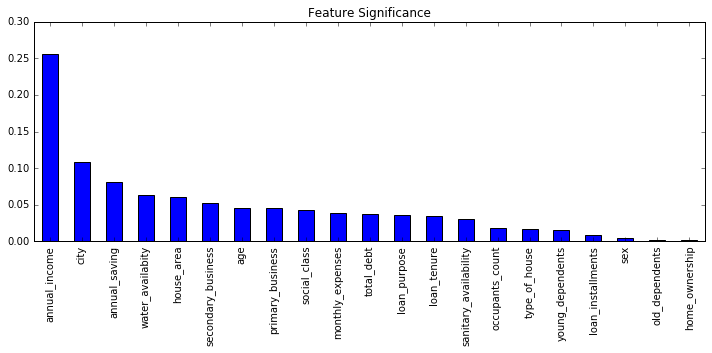

In [2]:
# treating outliers
cols = ['age', 'loan_amount', 'annual_income']

for i in cols:
    ulimit = np.percentile(XO[i].values, 99.9)
    llimit = np.percentile(XO[i].values, .1)
    XO[i].ix[XO[i]>ulimit] = ulimit
    XO[i].ix[XO[i]<llimit] = llimit


yo = np.log(XO['loan_amount'])
#y = X['loan_amount']
XO.drop('loan_amount', axis=1, inplace=True)

XO.drop('Id', axis=1, inplace=True)

# data pre-processing & FE
XO.fillna(XO.median(), inplace=True)
XO = pd.DataFrame(XO)

cat_columns = XO.select_dtypes(['object']).columns

for i in cat_columns:
    XO[i] = XO[i].astype('category')
    
XO[cat_columns] = XO[cat_columns].apply(lambda x: x.cat.codes)

XO['annual_saving'] = XO['annual_income'] - (12*XO['monthly_expenses'])
XO['total_debt'] = XO['loan_tenure'] * XO['loan_installments']
XO['house_area'] = np.log(XO['house_area']+1)

# split train & test
X, X_test, y, y_test = cross_validation.train_test_split(
            XO, yo, test_size=.20, random_state=SEED)

SEED = 123

'''
features_f = np.asarray(['city', 'social_class', 'annual_income', 'water_availabity',  'secondary_business',
                         'annual_saving','occupants_count', 'primary_business', 'loan_purpose', 
                         'monthly_expenses', 'house_area', 'total_debt', 'young_dependents', 
                         'loan_installments', 'sanitary_availability',  'loan_tenure', 'age', 'sex', 
                         'old_dependents', 'home_ownership', 'type_of_house'])
'''
#X = SelectKBest(f_regression, k=20).fit_transform(X, y)
#X = pd.DataFrame(X)
features_f = X.columns

print(features_f)

training_accuracy = []
cv_accuracy = []
test_accuracy = []

#nf = range(0, features_f.size)
nf = [1]

X1 = X

for m in nf:
    
    print("===========================") 
    features = features_f
    #features = features_f[0:m+1]
    X = X1[features]
    
    # === training & metrics === #
    mean_r2str = 0.0
    mean_r2scv = 0.0
    n = 5  # repeat the CV procedure 10 times to get more precise results
    
    # cross-validation
    for i in range(n):

        # split cv
        X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(
            X, y, test_size=.20, random_state=SEED)

        # modeling
        model = RandomForestRegressor()

        # train model and make predictions on cv
        model.fit(X_train, y_train)

        predstr = model.predict(X_train)
        predscv = model.predict(X_cv)
        
        '''
        importances = model.feature_importances_
        indices = np.argsort(importances)

        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), features) ## removed [indices]
        plt.xlabel('Relative Importance')
        plt.show()
        '''
        # Explained variance score: 1 is perfect prediction
        #print('Variance score: %.2f' % r2_score(y_cv, preds))
     
        # compute MSE metric for this CV fold
        r2str = r2_score(y_train, predstr)
        r2scv = r2_score(y_cv, predscv)

        #print("R2S Train: %f" % r2str)
        #print("R2S CV: %f" % r2scv)

        mean_r2str += r2str
        mean_r2scv += r2scv

    # print mse
    print("Mean R2S Train: %f" % (mean_r2str/n))
    print("Mean R2S CV: %f" % (mean_r2scv/n))
    print("---------------------------")
    training_accuracy.append(mean_r2str/n)
    cv_accuracy.append(mean_r2scv/n) 
    

# prediction
model = RandomForestRegressor()
model.fit(X, y)
'''
scorer = make_scorer(mean_squared_error, False)
cv_score = np.sqrt(-cross_val_score(estimator=model, X=X, y=y, cv=10, scoring = scorer))
print("MSE CV: ")
cv_score
'''
y_pred = model.predict(X_test)
r2ste = r2_score(y_test, y_pred)
print("R2S Test: %f" % r2ste)

coef = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

'''
#plt.plot(nf, training_accuracy, label="train accuracy")
plt.plot(nf, cv_accuracy, label="cv accuracy")
#plt.plot(nf, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Features")
plt.legend()
'''